# Scientific Portfolio Optimization: A Risk-Adjusted Comparison

This notebook evaluates multiple portfolio optimization strategies — both traditional and ML-enhanced — using scientific backtesting and risk-adjusted metrics.


**Imports**

In [5]:
# Core imports
import sys
import importlib
import warnings
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Project modules
import rebalancing
import mean_variance_optimization as mv
import machine_learning_strategies as mls
import portfolio_statistics as ps
from hrp import get_hrp_allocation
from rp import get_risk_parity_weights

# Rebalancing utilities
from rebalancing import (
    run_monthly_rebalanced_strategies,
    run_monthly_weight_snapshots,
    backtest_strategies_with_weights
)

# Portfolio statistics utilities
from portfolio_statistics import (
    sharpe_ratio_monthly,
    sortino_ratio_monthly,
    max_drawdown,
    annualized_volatility_monthly
)


#warnings
warnings.filterwarnings("ignore")
today = dt.date.today().strftime("%Y-%m-%d")

#reload custom modules during development
importlib.reload(rebalancing)
importlib.reload(mls)
importlib.reload(ps)


<module 'portfolio_statistics' from 'C:\\Users\\naifa\\OneDrive\\Masters Project\\scripts\\ML-Portfolio-Optimization2\\ML-Portfolio-Optimization1.2 - Copy\\portfolio_statistics.py'>

In [7]:

# Define the tickers and portfolio
tickers = [
    'SPY', 'TLT', 'GLD', 'VNQ', 'EFA', 'EEM', 'XLF', 'XLK',
    'XLP', 'XLY', 'XLU', 'XLE', 'TIP', 'HYG', 'LQD', 'DBC'
]
equal_weight = 1000.0
portfolio = {ticker: equal_weight for ticker in tickers}

# Rebalancing parameters
risk_free_rate = 0.04
max_volatility = 0.99
min_weight = 0.0
max_weight = 1.0

## Full Sample Performence (2020-2025)

In [15]:
monthly_results, weight_dfs = backtest_strategies_with_weights(
    portfolio_dict=portfolio,
    start_date='2015-01-01',# start date should take in account the training window
    end_date=today,
    training_window_years=5,
    max_volatility=max_volatility,
    min_weight=min_weight,
    max_weight=max_weight,
    rebalance_freq='M',
    target_mode='raw',      
    include_spy=False,
    compute_turnover=True
)


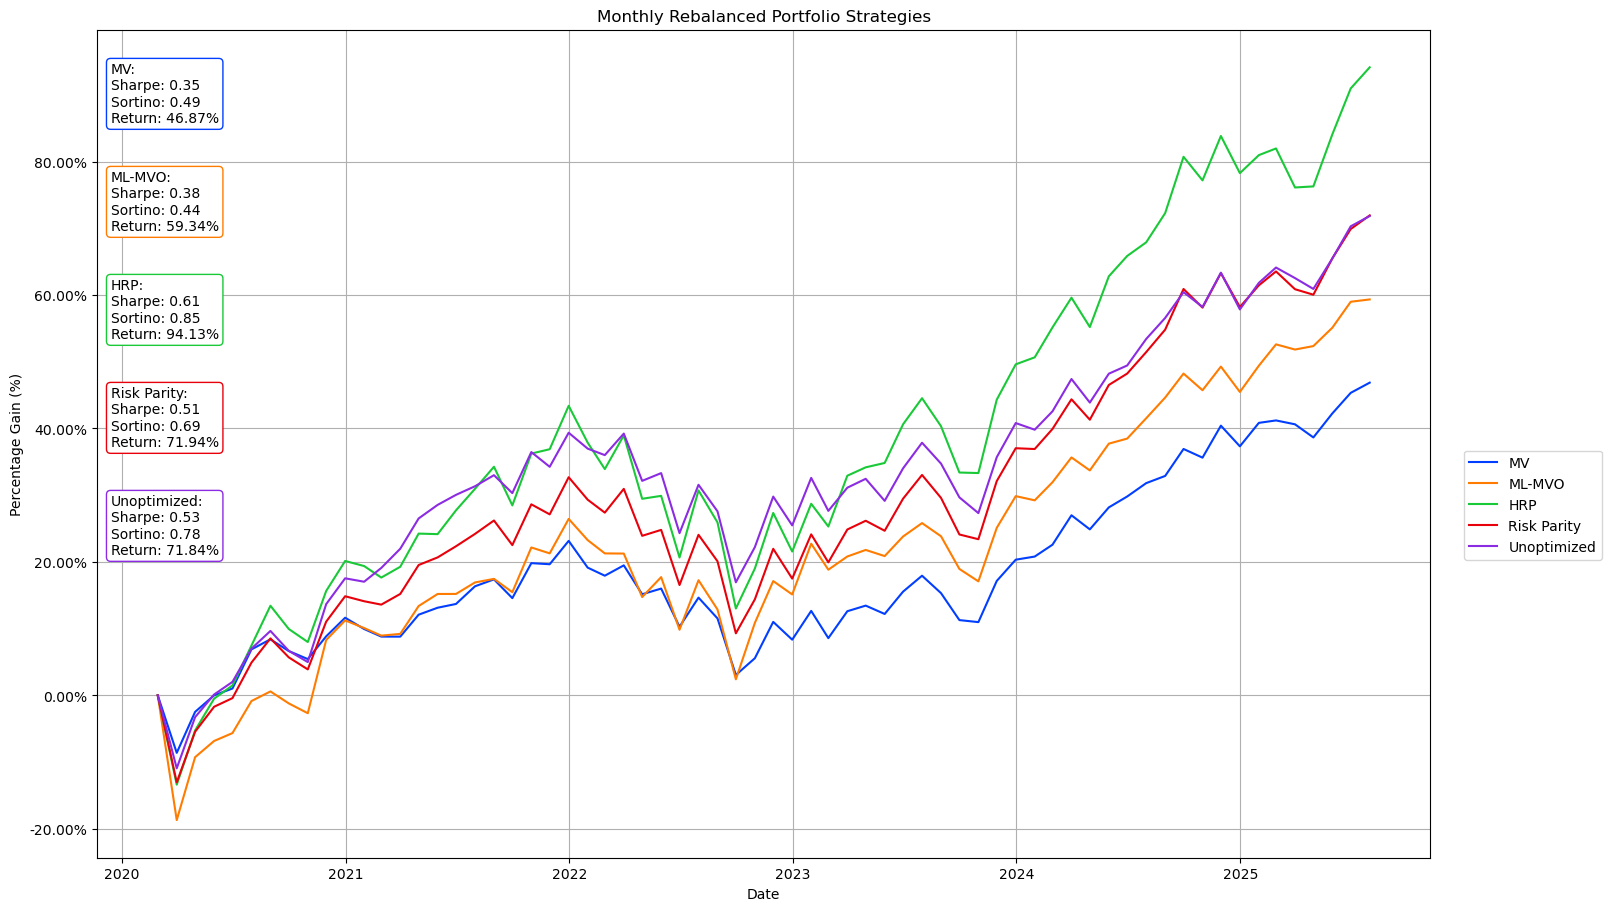


 Strategy Performance Summary:
      Strategy  Sharpe  Sortino  Return (%)  Volatility  Max Drawdown
2          HRP   0.614    0.854       94.13       0.155        -0.212
1       ML-MVO   0.379    0.442       59.34       0.154        -0.190
0           MV   0.352    0.491       46.87       0.104        -0.163
3  Risk Parity   0.513    0.688       71.94       0.136        -0.176
4  Unoptimized   0.535    0.779       71.84       0.128        -0.161


In [16]:
# --- Config / style (define risk_free_rate earlier) ---
plt.figure(figsize=(16, 9), constrained_layout=True)
ax = plt.gca()
sns.set_palette("bright")
colors = sns.color_palette()

plt.gcf().set_facecolor('white')
ax.set_facecolor('white')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2f}%'.format(y)))
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# --- Separate turnover & strategy curves ---
turnover_results = {k: v for k, v in monthly_results.items() if k.startswith("Turnover")}
raw_results      = {k: v for k, v in monthly_results.items()
                    if not k.startswith("Turnover") and isinstance(v, pd.Series) and not v.empty}

raw_results = {k: v for k, v in raw_results.items() if k != "SPY"}

# --- Build a common monthly evaluation calendar & rebase ---
if not raw_results:
    raise ValueError("No valid strategy series to plot.")

# Align start date where all strategies have data
common_start = max(s.first_valid_index() for s in raw_results.values() if isinstance(s, pd.Series))

# Force monthly, stair-step for non-monthly series; then rebase to 1
eval_monthly = {
    name: (series.loc[common_start:].resample('M').last().ffill() / series.loc[common_start:].resample('M').last().ffill().iloc[0])
    for name, series in raw_results.items()
}

# Merge back turnover without touching them
monthly_results_clean = {**eval_monthly, **turnover_results}

# --- Plot & collect metrics ---
strategy_metrics = {}
plot_names = [k for k in eval_monthly.keys()]  # plot only strategies, not turnover

for idx, name in enumerate(plot_names):
    series = eval_monthly[name]
    if not isinstance(series, pd.Series) or series.empty:
        continue

    # % curve for plotting
    pct_curve = ((series - 1) * 100).dropna()
    plt.plot(pct_curve, label=name, color=colors[idx % len(colors)])

    # Monthly returns for metrics
    rets_m = series.pct_change().dropna()

    # Metrics (monthly variants)
    sharpe  = sharpe_ratio_monthly(rets_m, risk_free_rate)
    sortino = sortino_ratio_monthly(rets_m, risk_free_rate)
    vol     = annualized_volatility_monthly(rets_m)
    mdd     = max_drawdown(series)
    final_ret = (series.iloc[-1] - 1) * 100

    # In case functions return Series (edge cases), coerce to float
    def _to_float(x):
        if isinstance(x, pd.Series):
            return float(x.mean())
        return float(x)

    strategy_metrics[name] = {
        'Sharpe': _to_float(sharpe),
        'Sortino': _to_float(sortino),
        'Return': float(final_ret),
        'Volatility': _to_float(vol),
        'Max Drawdown': float(mdd),
    }

# --- Stat boxes (compact, left column) ---
y_base = 0.87
for idx, (name, m) in enumerate(strategy_metrics.items()):
    box = f"{name}:\nSharpe: {m['Sharpe']:.2f}\nSortino: {m['Sortino']:.2f}\nReturn: {m['Return']:.2f}%"
    plt.text(
        0.0655, y_base, s=box,
        transform=plt.gcf().transFigure,
        fontsize=10, color='black',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[idx % len(colors)], facecolor='white')
    )
    y_base -= 0.12

plt.title("Monthly Rebalanced Portfolio Strategies", color='black')
plt.xlabel("Date"); plt.ylabel("Percentage Gain (%)")
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 0.5), frameon=True)
plt.grid(True)
plt.show()

# --- Summary table (strategies only, no turnover) ---
summary_rows = []
for name, s in eval_monthly.items():
    rets_m = s.pct_change().dropna()
    row = {
        'Strategy': name,
        'Sharpe': round(float(sharpe_ratio_monthly(rets_m, risk_free_rate)), 3),
        'Sortino': round(float(sortino_ratio_monthly(rets_m, risk_free_rate)), 3),
        'Return (%)': round(float((s.iloc[-1] - 1) * 100), 2),
        'Volatility': round(float(annualized_volatility_monthly(rets_m)), 3),
        'Max Drawdown': round(float(max_drawdown(s)), 3),
    }
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows).sort_values(by='Strategy')
pd.set_option('display.max_columns', None)
print("\n Strategy Performance Summary:")
print(df_summary)


## Crisis period performence (GFC 2008, Covid-19)

In [37]:

crisis_periods = {
    "Global Financial Crisis": ("2003-09-01", "2009-06-30"),
    "COVID-19 Crash": ("2015-01-01", "2020-09-30")
} #start date shall be - training_window_years


results_by_crisis = {}
weights_by_crisis = {}

for crisis, (start, end) in crisis_periods.items():
    print(f"Running backtest for {crisis}")
    monthly_results, weight_dfs = backtest_strategies_with_weights(
        portfolio_dict=portfolio,
        start_date=start,
        end_date=end,
        training_window_years=5,
        max_volatility=max_volatility,
        min_weight=min_weight,
        max_weight=max_weight,
        rebalance_freq='M',
        target_mode='raw',
        include_spy=False,
        compute_turnover=True
    )
    results_by_crisis[crisis] = monthly_results
    weights_by_crisis[crisis] = weight_dfs


Running backtest for Global Financial Crisis
Running backtest for COVID-19 Crash



Crisis Strategy Metrics:
Crisis       COVID-19 Crash  Global Financial Crisis
Strategy                                            
HRP                    0.53                     1.00
ML-MVO                 0.18                     0.69
MV                     0.45                     1.01
Risk Parity            0.30                     0.87
Unoptimized            0.39                     0.44

Full Table Sorted:
                    Crisis     Strategy  Sharpe  Sortino  Max Drawdown  \
7           COVID-19 Crash          HRP   0.533    0.778        -0.134   
5           COVID-19 Crash           MV   0.447    0.727        -0.086   
9           COVID-19 Crash  Unoptimized   0.387    0.655        -0.109   
8           COVID-19 Crash  Risk Parity   0.296    0.468        -0.130   
6           COVID-19 Crash       ML-MVO   0.185    0.288        -0.149   
0  Global Financial Crisis           MV   1.009    4.049        -0.118   
2  Global Financial Crisis          HRP   0.995    2.911        -

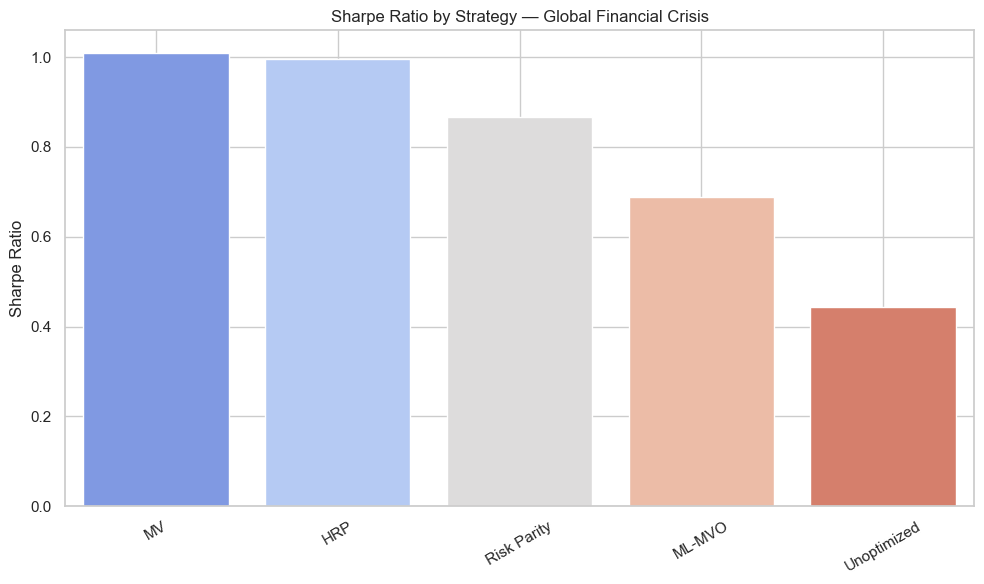

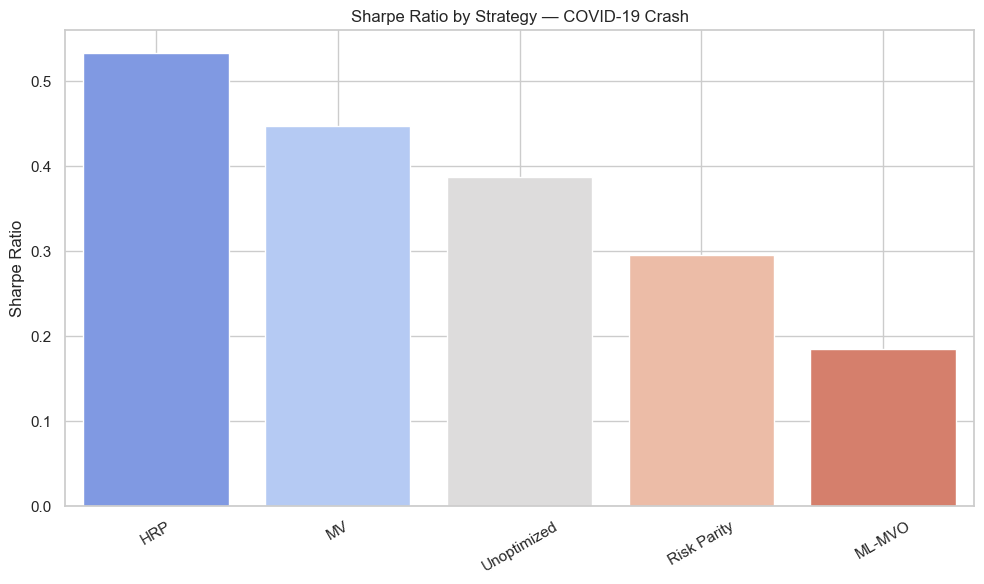

In [39]:

# === Compute Metrics ===
metrics_summary = []

for crisis, result_dict in results_by_crisis.items():
    for strategy_name, series in result_dict.items():
        if not isinstance(series, pd.Series) or series.empty:
            continue
        if strategy_name == "SPY" or strategy_name.startswith("Turnover"):
            continue
            
        returns = series.pct_change().dropna()
        
        so = sortino_ratio_monthly(returns, risk_free_rate, mar=0)  

        metrics_summary.append({
            "Crisis": crisis,
            "Strategy": strategy_name,
            "Sharpe": round(sharpe_ratio_monthly(returns, risk_free_rate), 3),
            "Sortino": round(float(so), 3) if pd.notna(so) else np.nan,
            "Max Drawdown": round(max_drawdown(series), 3),
            "Volatility (ann.)": round(annualized_volatility_monthly(returns), 3), 
            "Final Return (%)": round((series.iloc[-1] - 1) * 100, 2)
        })

# === Create DataFrame ===
df_metrics = pd.DataFrame(metrics_summary)

# === Print Metrics Table ===
print("\nCrisis Strategy Metrics:")
print(df_metrics.pivot(index="Strategy", columns="Crisis", values="Sharpe").round(2))

print("\nFull Table Sorted:")
print(df_metrics.sort_values(["Crisis", "Sharpe"], ascending=[True, False]))

# === Plotting ===
sns.set(style="whitegrid")
for crisis in df_metrics["Crisis"].unique():
    plt.figure(figsize=(10, 6))
    subset = df_metrics[df_metrics["Crisis"] == crisis].sort_values(by="Sharpe", ascending=False)
    sns.barplot(data=subset, x="Strategy", y="Sharpe", palette="coolwarm")
    plt.title(f"Sharpe Ratio by Strategy — {crisis}")
    plt.xlabel("")
    plt.ylabel("Sharpe Ratio")
    plt.xticks(rotation=30)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Sensitivity Test (Applying min_wieght & max_wiegth Constraints)

In [22]:
# Run backtest on monthly rebalancing 
monthly_results, weight_dfs = backtest_strategies_with_weights(
    portfolio_dict=portfolio,
    start_date='2015-01-01',
    end_date=today,
    training_window_years=5,
    max_volatility=max_volatility,
    min_weight=0.01,# min wieght aaplied
    max_weight=0.25,# max wieght applied
    rebalance_freq='M',
    target_mode='raw',      # or 'excess_spy' if that's your ML view
    include_spy=False,
    compute_turnover=True
)



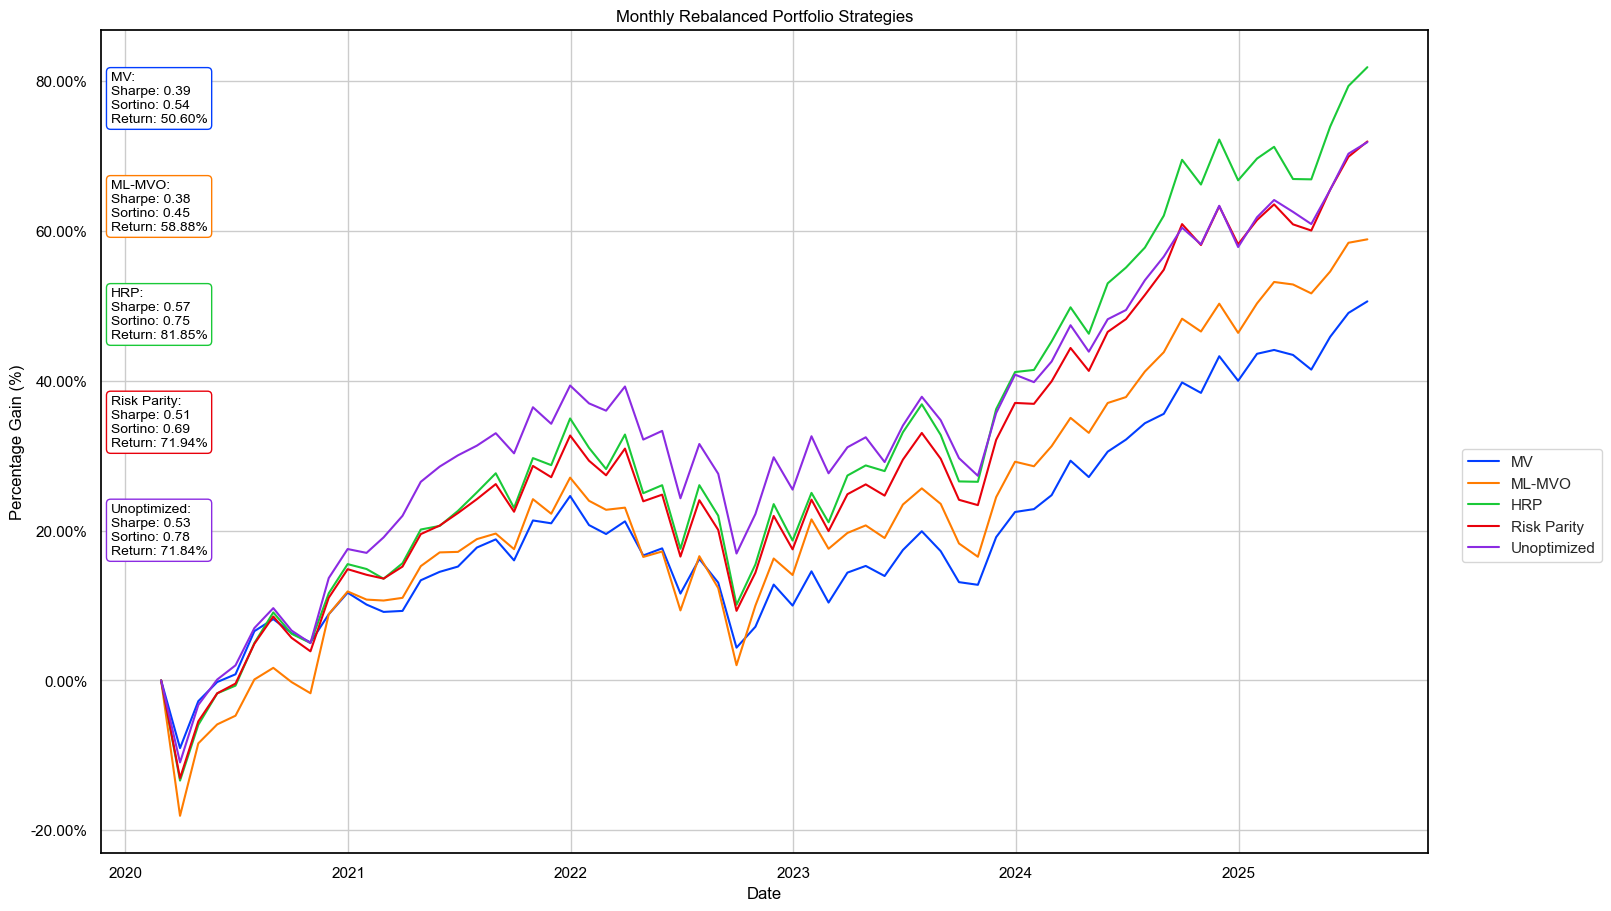


 Strategy Performance Summary:
      Strategy  Sharpe  Sortino  Return (%)  Volatility  Max Drawdown
2          HRP   0.565    0.753       81.85       0.144        -0.184
1       ML-MVO   0.379    0.450       58.88       0.151        -0.197
0           MV   0.390    0.540       50.60       0.106        -0.162
3  Risk Parity   0.513    0.688       71.94       0.136        -0.176
4  Unoptimized   0.535    0.779       71.84       0.128        -0.161


In [27]:
# --- Config / style (define risk_free_rate earlier) ---
plt.figure(figsize=(16, 9), constrained_layout=True)
ax = plt.gca()
sns.set_palette("bright")
colors = sns.color_palette()

plt.gcf().set_facecolor('white')
ax.set_facecolor('white')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2f}%'.format(y)))
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# --- Separate turnover & strategy curves ---
turnover_results = {k: v for k, v in monthly_results.items() if k.startswith("Turnover")}
raw_results      = {k: v for k, v in monthly_results.items()
                    if not k.startswith("Turnover") and isinstance(v, pd.Series) and not v.empty}

raw_results = {k: v for k, v in raw_results.items() if k != "SPY"}

# --- Build a common monthly evaluation calendar & rebase ---
if not raw_results:
    raise ValueError("No valid strategy series to plot.")

# Align start date where all strategies have data
common_start = max(s.first_valid_index() for s in raw_results.values() if isinstance(s, pd.Series))

# Force monthly, stair-step for non-monthly series; then rebase to 1
eval_monthly = {
    name: (series.loc[common_start:].resample('M').last().ffill() / series.loc[common_start:].resample('M').last().ffill().iloc[0])
    for name, series in raw_results.items()
}

# Merge back turnover without touching them
monthly_results_clean = {**eval_monthly, **turnover_results}

# --- Plot & collect metrics ---
strategy_metrics = {}
plot_names = [k for k in eval_monthly.keys()]  # plot only strategies, not turnover

for idx, name in enumerate(plot_names):
    series = eval_monthly[name]
    if not isinstance(series, pd.Series) or series.empty:
        continue

    # % curve for plotting
    pct_curve = ((series - 1) * 100).dropna()
    plt.plot(pct_curve, label=name, color=colors[idx % len(colors)])

    # Monthly returns for metrics
    rets_m = series.pct_change().dropna()

    # Metrics (monthly variants)
    sharpe  = sharpe_ratio_monthly(rets_m, risk_free_rate)
    sortino = sortino_ratio_monthly(rets_m, risk_free_rate)
    vol     = annualized_volatility_monthly(rets_m)
    mdd     = max_drawdown(series)
    final_ret = (series.iloc[-1] - 1) * 100

    # In case functions return Series (edge cases), coerce to float
    def _to_float(x):
        if isinstance(x, pd.Series):
            return float(x.mean())
        return float(x)

    strategy_metrics[name] = {
        'Sharpe': _to_float(sharpe),
        'Sortino': _to_float(sortino),
        'Return': float(final_ret),
        'Volatility': _to_float(vol),
        'Max Drawdown': float(mdd),
    }

# --- Stat boxes (compact, left column) ---
y_base = 0.87
for idx, (name, m) in enumerate(strategy_metrics.items()):
    box = f"{name}:\nSharpe: {m['Sharpe']:.2f}\nSortino: {m['Sortino']:.2f}\nReturn: {m['Return']:.2f}%"
    plt.text(
        0.0655, y_base, s=box,
        transform=plt.gcf().transFigure,
        fontsize=10, color='black',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[idx % len(colors)], facecolor='white')
    )
    y_base -= 0.12

plt.title("Monthly Rebalanced Portfolio Strategies", color='black')
plt.xlabel("Date"); plt.ylabel("Percentage Gain (%)")
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 0.5), frameon=True)
plt.grid(True)
plt.show()

# --- Summary table (strategies only, no turnover) ---
summary_rows = []
for name, s in eval_monthly.items():
    rets_m = s.pct_change().dropna()
    row = {
        'Strategy': name,
        'Sharpe': round(float(sharpe_ratio_monthly(rets_m, risk_free_rate)), 3),
        'Sortino': round(float(sortino_ratio_monthly(rets_m, risk_free_rate)), 3),
        'Return (%)': round(float((s.iloc[-1] - 1) * 100), 2),
        'Volatility': round(float(annualized_volatility_monthly(rets_m)), 3),
        'Max Drawdown': round(float(max_drawdown(s)), 3),
    }
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows).sort_values(by='Strategy')
pd.set_option('display.max_columns', None)
print("\n Strategy Performance Summary:")
print(df_summary)


## Calculating Wieghts over the backtest period

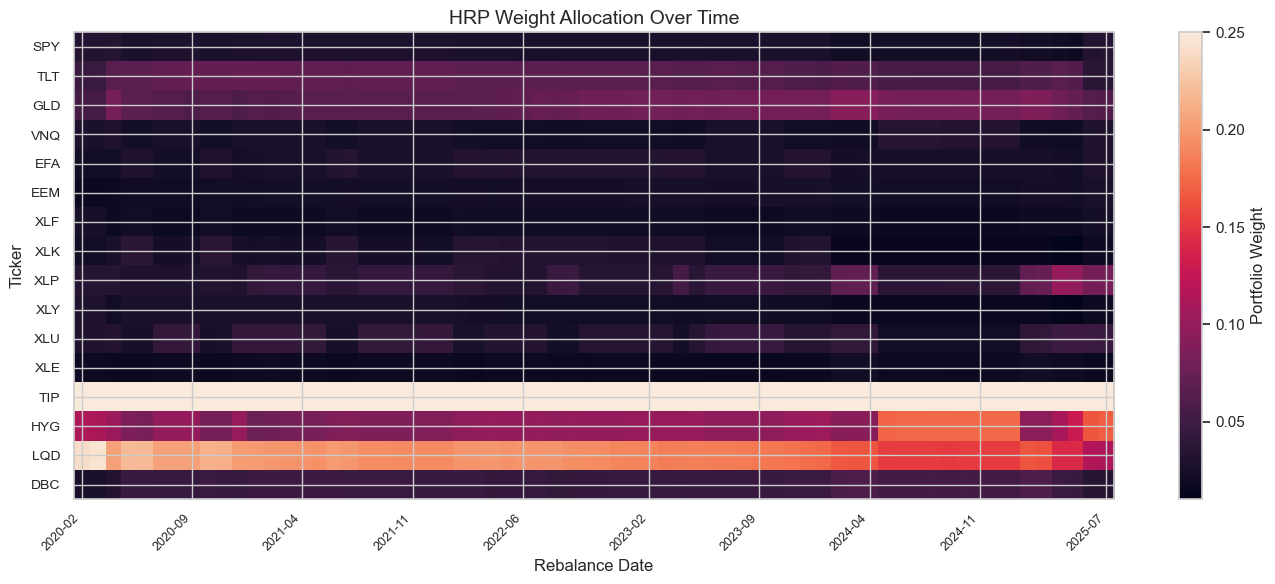

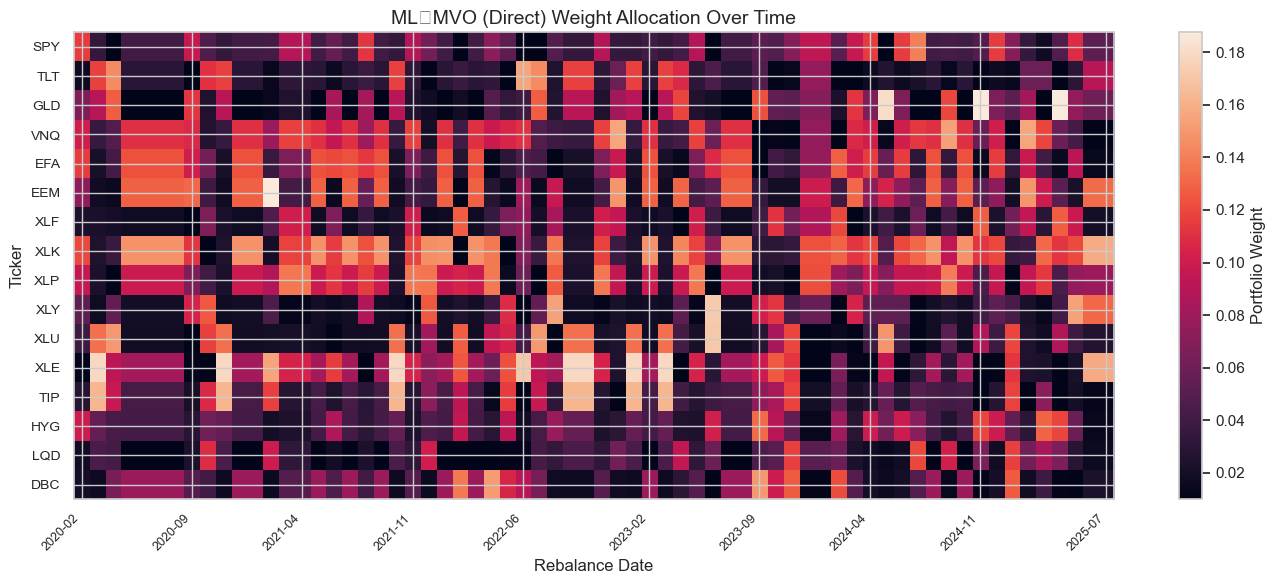

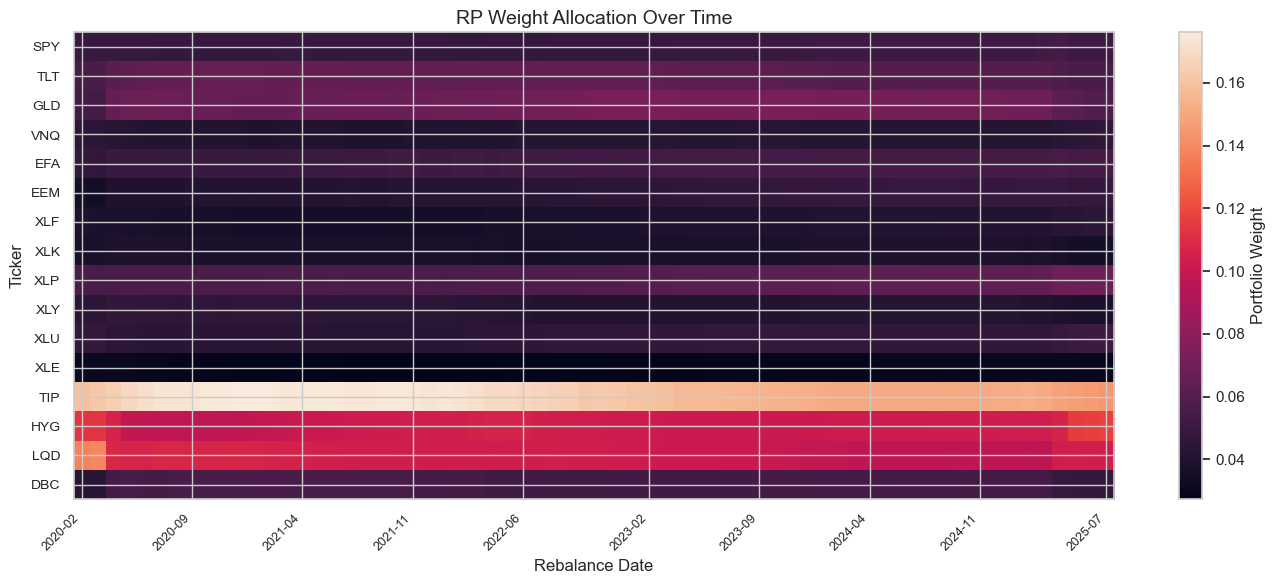

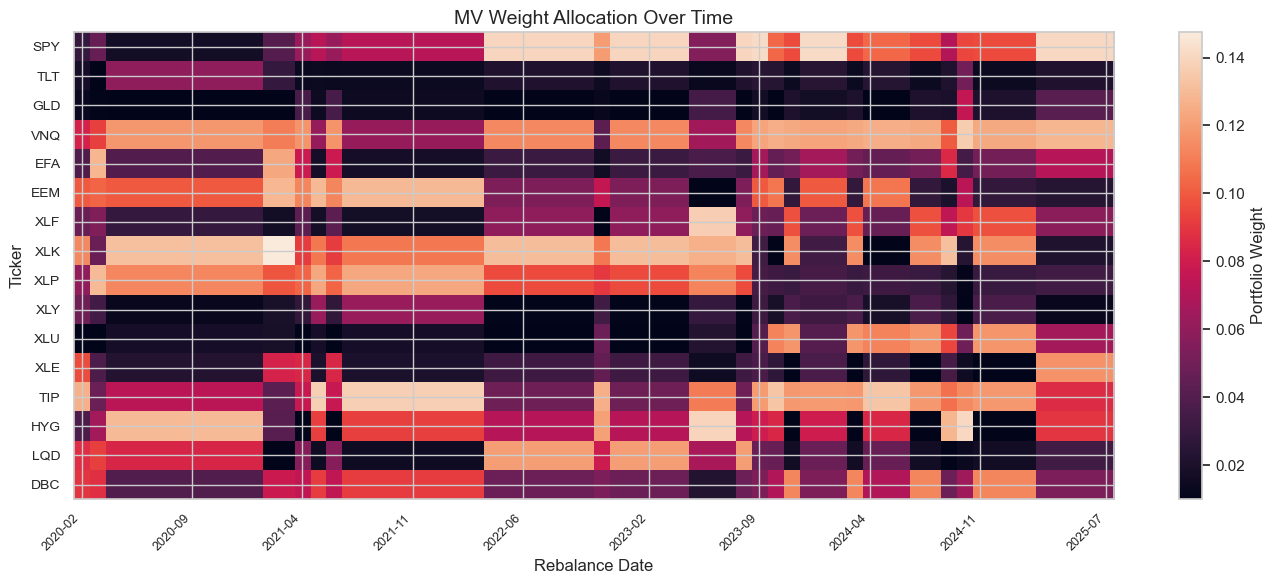

In [29]:
def weight_heatmap(weights_df: pd.DataFrame, title: str = "Weights Over Time"):
    if not isinstance(weights_df.index, pd.DatetimeIndex):
        weights_df = weights_df.copy()
        weights_df.index = pd.to_datetime(weights_df.index)

    W = weights_df.copy().sort_index().fillna(0.0).clip(0.0, 1.0)

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(W.values.T, aspect='auto', interpolation='nearest')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Rebalance Date")
    ax.set_ylabel("Ticker")

    ax.set_yticks(np.arange(W.shape[1]))
    ax.set_yticklabels(W.columns, fontsize=10)

    xticks = np.linspace(0, W.shape[0]-1, num=min(10, W.shape[0])).astype(int)
    ax.set_xticks(xticks)
    ax.set_xticklabels([W.index[i].strftime('%Y-%m') for i in xticks], rotation=45, ha='right', fontsize=9)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Portfolio Weight", rotation=90)
    fig.tight_layout()
    plt.show()


weight_heatmap(weight_dfs['HRP'],   "HRP Weight Allocation Over Time")
weight_heatmap(weight_dfs['ML-MVO'], "ML‑MVO (Direct) Weight Allocation Over Time")
weight_heatmap(weight_dfs['Risk Parity'],   "RP Weight Allocation Over Time")
weight_heatmap(weight_dfs['MV'],   "MV Weight Allocation Over Time")
